# <font color='darkblue'>__03 · Graph Model with Neo4j (Cypher)B__</font>

**Ziele**
- Daten als **Graph** modellieren und importieren (Users, Posts; FOLLOWS/AUTHORED/LIKES/COMMENTED)
- Indizes/Constraints setzen
- Die fünf Kernfragen **Q1–Q5** als Cypher-Queries lösen
- Vergleichbar zu SQLite & MongoDB (gleiche Fragestellungen)

👉 Dieses Notebook verbindet sich **resilient** zu Neo4j und gibt klare Hinweise, falls kein Server läuft.

**Voraussetzungen**
- Laufender Neo4j (Desktop, Docker oder Aura)
- Python-Pakete: `pip install --user -U neo4j pandas matplotlib python-dateutil tqdm`
- **Option 1: Setup mit Neo4J Desktop**:
  - Neo4j Desktop öffnen → Projects → New → Create Project
  - Add → Local DBMS (Version 5.x)
  - DBMS-Name ist frei wählbar (z. B. „workshop“)
  - Beim ersten Start wirst du nach einem Passwort gefragt — setze z. B. test1234 (oder eigenes)
  - Start klicken
  - rüfen: Web-UI unter http://localhost:7474 öffnet sich, Login mit neo4j / <deinPasswort>
    - Bolt-Port ist normalerweise 7687 (falls anders, in den DB Settings nachsehen).

    
- **Option 2: Setup mit Docker**, Schnellstart (Neo4j 5):
  - PowerShell:
  ```powershell
  docker run -d --name neo4j -p 7474:7474 -p 7687:7687 `
    -e NEO4J_AUTH=neo4j/test1234 `
    -e NEO4J_dbms_memory_heap_initial__size=512m `
    -e NEO4J_dbms_memory_heap_max__size=1g `
    neo4j:5
  ```
    
  - Web-UI: http://localhost:7474 (Login neo4j / test1234)
    
    
**Ordnerstruktur (relativ zum Notebook)**
```
notebooks/
  03_neo4j.ipynb
  data/
    graph/
      nodes.csv     # id,label,username?
      edges.csv     # src,dst,type,since/at
```


---

In [2]:
# ## Setup & Verbindung (resilient)
from pathlib import Path
import os, pandas as pd
from neo4j import GraphDatabase
from datetime import datetime, timedelta
from dateutil import parser as dateparser
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm


# Relative Pfade
BASE = Path('.').resolve()
GRAPH = BASE / 'data' / 'graph'

print('Notebook base:', BASE)
print('Graph data path:', GRAPH)

# Verbindungsparameter (überschreibbar via Umgebungsvariablen)
NEO4J_URIS = [
    os.environ.get('NEO4J_URI') or 'bolt://localhost:7687',
    'bolt://127.0.0.1:7687',
]
NEO4J_USER = os.environ.get('NEO4J_USER', 'neo4j')
NEO4J_PASSWORD = os.environ.get('NEO4J_PASSWORD', 'test1234')  # lokal anpassen

driver = None
NEO4J_OK = False
CONNECTED_URI = None
for uri in NEO4J_URIS:
    try:
        drv = GraphDatabase.driver(uri, auth=(NEO4J_USER, NEO4J_PASSWORD))
        with drv.session() as s:
            ver = s.run('CALL dbms.components() YIELD versions RETURN versions[0] AS version').data()
        driver = drv
        CONNECTED_URI = uri
        NEO4J_OK = True
        print(f'✅ Verbunden mit Neo4j @ {uri} | Version:', ver[0]['version'] if ver else 'unknown')
        break
    except Exception as e:
        print(f'⚠️  Verbindung zu {uri} fehlgeschlagen: {e}')

if not NEO4J_OK:
    print('\n❌ Konnte keine Neo4j-Verbindung herstellen.')
    print('Bitte prüfe:')
    print('  1) Läuft Neo4j? (Desktop: DB starten | Docker: siehe Befehl im Intro)')
    print('  2) Firewall/Port 7687 freigegeben?')
    print('  3) URI/Passwort korrekt? Setze ggf. Umgebungsvariablen NEO4J_URI/USER/PASSWORD.')


Notebook base: C:\Users\pell\Documents\3__UNTERRICHT_STUDENTENBETREUUNG\MAS_BE\CAS Data Engineering\2025\06_Storage\_ChatGPT
Graph data path: C:\Users\pell\Documents\3__UNTERRICHT_STUDENTENBETREUUNG\MAS_BE\CAS Data Engineering\2025\06_Storage\_ChatGPT\data\graph
✅ Verbunden mit Neo4j @ bolt://localhost:7687 | Version: 5.20.0


### 💡 Connectivity-Notizen (Windows)
- Wenn `localhost` auf IPv6 (`::1`) auflöst und blockiert ist, nutzen wir automatisch `127.0.0.1`.
- **Neo4j Desktop**: Stelle sicher, dass die DB **läuft** und notiere das Passwort.  
- **Docker**: siehe Befehl im Intro (öffnet 7474/7687). Web-UI ist dann unter http://localhost:7474 erreichbar.
- **Aura**: Setze `NEO4J_URI` auf deine Aura-URI, z. B. `neo4j+s://<id>.databases.neo4j.io` (SSL!).


In [3]:
# ## Helper
def show_df(df, n=10):
    try:
        from IPython.display import display
        display(df.head(n))
    except Exception:
        print(df.head(n).to_json(orient='records'))

def require_neo4j():
    if not globals().get('NEO4J_OK', False):
        raise SystemExit('Neo4j ist nicht verbunden. Starte Neo4j und führe die Setup-Zelle erneut aus.')

def run_query(query, params=None):
    require_neo4j()
    with driver.session() as s:
        result = s.run(query, params or {})
        return [r.data() for r in result]


In [4]:
# ## Daten laden (Preview aus CSV)
require_neo4j()

import pandas as pd
nodes_path = GRAPH / 'nodes.csv'
edges_path = GRAPH / 'edges.csv'

if not nodes_path.exists() or not edges_path.exists():
    raise FileNotFoundError(f"Fehlende Dateien in {GRAPH}. Erwartet: nodes.csv, edges.csv")

nodes_df = pd.read_csv(nodes_path)
edges_df = pd.read_csv(edges_path)

show_df(nodes_df, 5)
show_df(edges_df, 5)


,id,label,username
0,user:1,User,user_qahftr
1,user:2,User,user_ckafna
2,user:3,User,user_ssklhw
3,user:4,User,user_sieyic
4,user:5,User,user_jigbld


,src,dst,type,since,at
0,user:1,user:6,FOLLOWS,2025-05-10,NaN
1,user:1,user:151,FOLLOWS,2025-02-20,NaN
2,user:1,user:44,FOLLOWS,2025-03-19,NaN
3,user:1,user:21,FOLLOWS,2025-04-22,NaN
4,user:1,user:2,FOLLOWS,2025-04-16,NaN


In [5]:
# ## DB vorbereiten (Constraints/Indices) & optional Wipe
require_neo4j()

WIPE = False  # <- auf True setzen, wenn du einen Neuimport erzwingen willst

with driver.session() as s:
    if WIPE:
        s.run('MATCH (n) DETACH DELETE n')
        print('DB geleert.')

    s.run('CREATE CONSTRAINT user_id IF NOT EXISTS FOR (u:User) REQUIRE u.user_id IS UNIQUE')
    s.run('CREATE CONSTRAINT post_id IF NOT EXISTS FOR (p:Post) REQUIRE p.post_id IS UNIQUE')
    s.run('CREATE INDEX user_username IF NOT EXISTS FOR (u:User) ON (u.username)')

print('Constraints/Indices gesetzt.')


Constraints/Indices gesetzt.


In [6]:
# ## Import: Nodes
require_neo4j()

# nodes.csv: id,label,username?
# id hat Form 'user:123' oder 'post:456'
def import_nodes(batch_size=1000):
    users = []
    posts = []
    for _, row in nodes_df.iterrows():
        rid = str(row['id'])
        label = str(row['label'])
        if label == 'User':
            try:
                uid = int(rid.split(':',1)[1])
            except Exception:
                uid = None
            users.append({'user_id': uid, 'username': row.get('username', None)})
        elif label == 'Post':
            try:
                pid = int(rid.split(':',1)[1])
            except Exception:
                pid = None
            posts.append({'post_id': pid})

    with driver.session() as s:
        # Users
        for i in range(0, len(users), batch_size):
            batch = users[i:i+batch_size]
            s.run('''
            UNWIND $rows AS row
            MERGE (u:User {user_id: row.user_id})
            SET u.username = COALESCE(row.username, u.username)
            ''', rows=batch)
        # Posts
        for i in range(0, len(posts), batch_size):
            batch = posts[i:i+batch_size]
            s.run('''
            UNWIND $rows AS row
            MERGE (p:Post {post_id: row.post_id})
            ''', rows=batch)

    print(f"Importiert: Users={len(users)}, Posts={len(posts)}")

import_nodes()


Importiert: Users=200, Posts=865


In [7]:
# ## Import: Edges
require_neo4j()

# edges.csv: src,dst,type, since/at
# Types: FOLLOWS (user->user, since: date), AUTHORED (user->post, at: datetime),
#        LIKES (user->post, at), COMMENTED (user->post, at)

def parse_id(id_str):
    kind, num = str(id_str).split(':',1)
    return kind, int(num)

def import_edges(batch_size=1000):
    by_type = {'FOLLOWS': [], 'AUTHORED': [], 'LIKES': [], 'COMMENTED': []}
    for _, row in edges_df.iterrows():
        typ = str(row['type']).upper()
        if typ not in by_type:
            continue
        src_kind, src_num = parse_id(row['src'])
        dst_kind, dst_num = parse_id(row['dst'])
        payload = {'src': src_num, 'dst': dst_num,
                   'since': row.get('since', None),
                   'at': row.get('at', None)}
        by_type[typ].append(payload)

    with driver.session() as s:
        # FOLLOWS
        data = by_type['FOLLOWS']
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            s.run('''
            UNWIND $rows AS row
            MATCH (u1:User {user_id: row.src}), (u2:User {user_id: row.dst})
            MERGE (u1)-[r:FOLLOWS]->(u2)
            SET r.since = CASE WHEN row.since IS NULL OR row.since = '' THEN null ELSE date(row.since) END
            ''', rows=batch)

        # AUTHORED
        data = by_type['AUTHORED']
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            s.run('''
            UNWIND $rows AS row
            MATCH (u:User {user_id: row.src}), (p:Post {post_id: row.dst})
            MERGE (u)-[r:AUTHORED]->(p)
            SET r.at = CASE WHEN row.at IS NULL OR row.at = '' THEN null ELSE datetime(row.at) END
            ''', rows=batch)

        # LIKES
        data = by_type['LIKES']
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            s.run('''
            UNWIND $rows AS row
            MATCH (u:User {user_id: row.src}), (p:Post {post_id: row.dst})
            MERGE (u)-[r:LIKES]->(p)
            SET r.at = CASE WHEN row.at IS NULL OR row.at = '' THEN null ELSE datetime(row.at) END
            ''', rows=batch)

        # COMMENTED
        data = by_type['COMMENTED']
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            s.run('''
            UNWIND $rows AS row
            MATCH (u:User {user_id: row.src}), (p:Post {post_id: row.dst})
            MERGE (u)-[r:COMMENTED]->(p)
            SET r.at = CASE WHEN row.at IS NULL OR row.at = '' THEN null ELSE datetime(row.at) END
            ''', rows=batch)

    print("Kanten importiert:", {k: len(v) for k,v in by_type.items()})

import_edges()


Kanten importiert: {'FOLLOWS': 3047, 'AUTHORED': 865, 'LIKES': 1266, 'COMMENTED': 512}


In [8]:
stats = run_query("""
MATCH (u:User)            RETURN 'User'       AS what, count(u) AS cnt
UNION ALL
MATCH (p:Post)            RETURN 'Post'       AS what, count(p) AS cnt
UNION ALL
MATCH ()-[r:FOLLOWS]->()  RETURN 'FOLLOWS'    AS what, count(r) AS cnt
UNION ALL
MATCH ()-[r:AUTHORED]->() RETURN 'AUTHORED'   AS what, count(r) AS cnt
UNION ALL
MATCH ()-[r:LIKES]->()    RETURN 'LIKES'      AS what, count(r) AS cnt
UNION ALL
MATCH ()-[r:COMMENTED]->() RETURN 'COMMENTED' AS what, count(r) AS cnt
""")
show_df(pd.DataFrame(stats).sort_values("what"), 10)


,what,cnt
3,AUTHORED,865
5,COMMENTED,509
2,FOLLOWS,3047
4,LIKES,1266
1,Post,865
0,User,200


## Q1 · Aktivste Nutzer:innen (Engagement)
Berechne Posts, Kommentare, Likes pro User und die Summe als Engagement-Score.


In [9]:
require_neo4j()
import pandas as pd
rows = run_query('''
MATCH (u:User)
OPTIONAL MATCH (u)-[:AUTHORED]->(:Post)
WITH u, count(*) AS posts
OPTIONAL MATCH (u)-[:COMMENTED]->(:Post)
WITH u, posts, count(*) AS comments
OPTIONAL MATCH (u)-[:LIKES]->(:Post)
WITH u, posts, comments, count(*) AS likes
RETURN u.user_id AS user_id, u.username AS username,
       posts, comments, likes,
       (posts + comments + likes) AS engagement_score
ORDER BY engagement_score DESC, posts DESC
LIMIT 20
''')
df_q1 = pd.DataFrame(rows)
show_df(df_q1, 10)


,user_id,username,posts,comments,likes,engagement_score
0,94,user_ethptp,10,4,12,26
1,107,user_nmcbli,10,5,11,26
2,35,user_eycepr,5,6,14,25
3,11,user_kbxosf,8,4,12,24
4,156,user_muncny,10,6,7,23
5,43,user_rwngxb,9,3,11,23
6,104,user_yuqryl,7,7,9,23
7,15,user_kpmgoy,12,2,8,22
8,198,user_aitdje,9,3,10,22
9,138,user_qxqilp,4,6,12,22


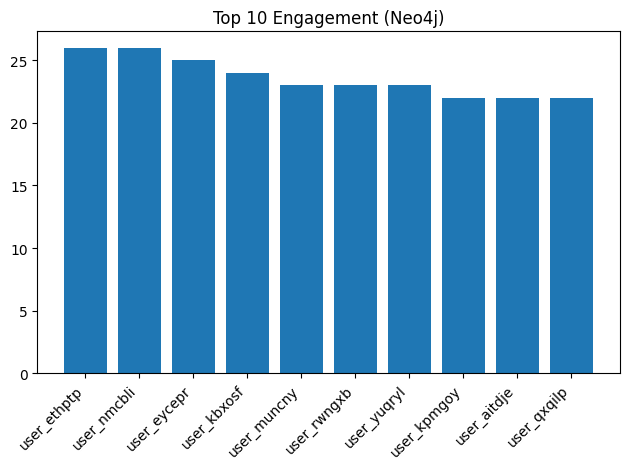

In [10]:
# Plot
import matplotlib.pyplot as plt
top10 = df_q1.head(10)
plt.figure()
plt.bar(top10['username'].fillna(top10['user_id'].astype(str)), top10['engagement_score'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Engagement (Neo4j)')
plt.tight_layout()


## Q2 · Beliebteste Posts (Likes)
Posts mit den meisten Likes, inkl. Autor:in und (aus AUTHORED abgeleitetem) Erstellungsdatum.


In [11]:
require_neo4j()
import pandas as pd
rows = run_query('''
MATCH (a:User)-[r:AUTHORED]->(p:Post)
OPTIONAL MATCH (p)<-[l:LIKES]-(:User)
RETURN p.post_id AS post_id,
       a.username AS author,
       date(r.at) AS day,
       count(l) AS like_count
ORDER BY like_count DESC, post_id ASC
LIMIT 20
''')
df_q2 = pd.DataFrame(rows)
show_df(df_q2, 10)


,post_id,author,day,like_count
0,136,user_ywemfk,2025-08-16,4
1,138,user_ywemfk,2025-08-26,4
2,184,user_nroycw,2025-08-13,4
3,291,user_djdfki,2025-08-26,4
4,292,user_djdfki,2025-09-05,4
5,293,user_djdfki,2025-08-26,4
6,336,user_zjquqt,2025-08-31,4
7,381,user_iwshay,2025-08-23,4
8,384,user_gkogms,2025-08-15,4
9,386,user_ucfrhp,2025-09-10,4


## Q3 · Graph-Insights
**Degrees**: Top Nutzer:innen nach Followern/Following.  
**Kürzester Pfad**: Demo mit `shortestPath` (richtungsgebunden entlang `FOLLOWS`).


In [12]:
require_neo4j()
import pandas as pd
rows = run_query('''
MATCH (u:User)
OPTIONAL MATCH (:User)-[:FOLLOWS]->(u)
WITH u, count(*) AS followers
OPTIONAL MATCH (u)-[:FOLLOWS]->(:User)
WITH u, followers, count(*) AS following
RETURN u.user_id AS user_id, u.username AS username, followers, following
ORDER BY followers DESC, following DESC
LIMIT 20
''')
df_deg = pd.DataFrame(rows)
show_df(df_deg, 10)


,user_id,username,followers,following
0,80,user_mgjpzs,27,23
1,90,user_gkogms,25,23
2,98,user_cbmprd,25,23
3,141,user_ticzdz,25,5
4,154,user_oucwdj,24,25
5,108,user_afrwpa,22,22
6,41,user_nroycw,22,22
7,71,user_kfkxps,22,22
8,91,user_ucfrhp,22,9
9,10,user_rfitbv,21,22


In [13]:
# Kürzester Pfad zwischen zwei zufälligen Usern (bis Länge 6)
require_neo4j()
import pandas as pd

uids = run_query('MATCH (u:User) WITH u ORDER BY rand() LIMIT 2 RETURN u.user_id AS uid')
if len(uids) == 2:
    src, dst = uids[0]['uid'], uids[1]['uid']
    print('Quelle:', src, 'Ziel:', dst)
    rows = run_query('''
    MATCH (a:User {user_id: $src}), (b:User {user_id: $dst})
    MATCH p = shortestPath( (a)-[:FOLLOWS*..6]->(b) )
    RETURN length(p) AS hops,
           [n IN nodes(p) | coalesce(n.username, toString(n.post_id))] AS path
    ''', {'src': src, 'dst': dst})
    if rows:
        print('Hops:', rows[0]['hops'])
        print('Pfad:', ' -> '.join(rows[0]['path']))
    else:
        print('Kein Pfad (gerichtet) innerhalb von 6 Hops gefunden.')
else:
    print('Nicht genug Nutzer im Datensatz?')


Quelle: 141 Ziel: 173
Hops: 3
Pfad: user_ticzdz -> user_gkogms -> user_okgwzp -> user_lhtclh


## Q4 · Trends über Zeit (Posts/Tag, 7d-Rolling)
Wir nutzen den Zeitstempel auf `[:AUTHORED].at` als Erstellungszeit des Posts.


In [14]:
rows = run_query("""
MATCH (:User)-[r:AUTHORED]->(:Post)
WHERE r.at IS NOT NULL
WITH date(r.at) AS day, count(*) AS posts
RETURN toString(day) AS day, posts
ORDER BY day
""")
df_trend = pd.DataFrame(rows)
df_trend["day"] = pd.to_datetime(df_trend["day"])
df_trend["rolling_7d"] = df_trend["posts"].rolling(7, min_periods=1).mean()
show_df(df_trend, 10)


,day,posts,rolling_7d
0,2025-08-12,22,22.000000
1,2025-08-13,24,23.000000
2,2025-08-14,31,25.666667
3,2025-08-15,39,29.000000
4,2025-08-16,31,29.400000
5,2025-08-17,28,29.166667
6,2025-08-18,38,30.428571
7,2025-08-19,23,30.571429
8,2025-08-20,29,31.285714
9,2025-08-21,30,31.142857


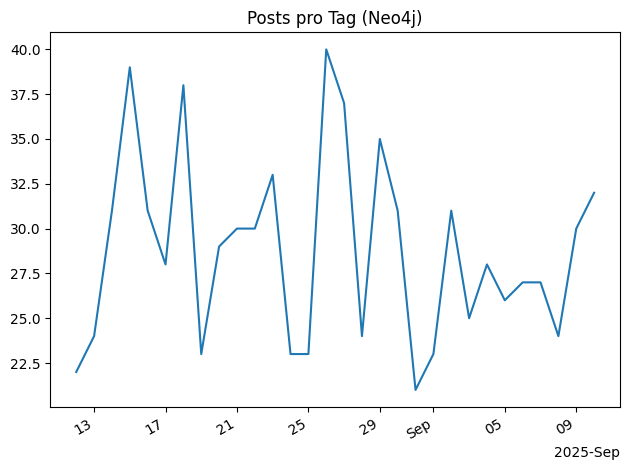

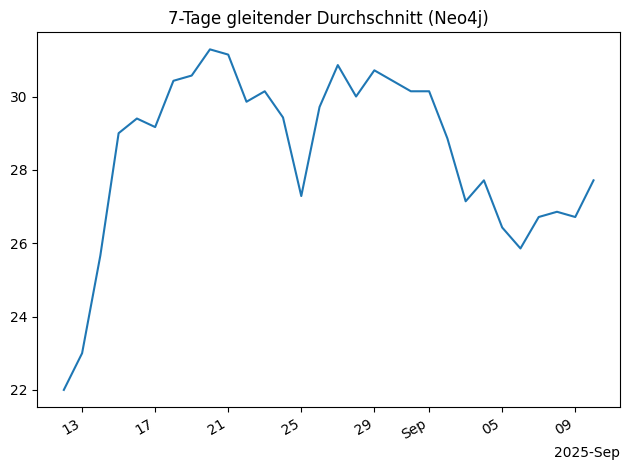

In [15]:
# Plot
plt.figure()
plt.plot(pd.to_datetime(df_trend['day']), df_trend['posts'])
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.gcf().autofmt_xdate()
plt.title('Posts pro Tag (Neo4j)')
plt.tight_layout()

plt.figure()
plt.plot(pd.to_datetime(df_trend['day']), df_trend['rolling_7d'])
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.gcf().autofmt_xdate()
plt.title('7-Tage gleitender Durchschnitt (Neo4j)')
plt.tight_layout()


## Q5 · Feed-Abfrage (Posts der Gefolgten in den letzten X Tagen)
Parameter: `viewer_user_id`, `days_back`


In [16]:
require_neo4j()
import pandas as pd
viewer_user_id = 1
days_back = 3

rows = run_query('''
WITH date(datetime()) AS today
MATCH (viewer:User {user_id: $viewer})-[:FOLLOWS]->(a:User)-[r:AUTHORED]->(p:Post)
WHERE date(r.at) >= (today - duration({days: $days_back}))
OPTIONAL MATCH (p)<-[l:LIKES]-(:User)
WITH p, a, r, count(l) AS like_count
RETURN p.post_id AS post_id, a.username AS author, r.at AS created_at, like_count
ORDER BY created_at DESC
LIMIT 50
''', {'viewer': viewer_user_id, 'days_back': days_back})
df_feed = pd.DataFrame(rows)
show_df(df_feed, 20)


,post_id,author,created_at,like_count
0,23,user_jigbld,2025-09-10T00:00:00.000000000+00:00,2
1,399,user_ethptp,2025-09-10T00:00:00.000000000+00:00,0
2,204,user_lhauqg,2025-09-09T00:00:00.000000000+00:00,3


## Zusammenfassung (Graphmodell · Neo4j)

**Stärken**
- Beziehungen sind **First-Class**: Traversals, kürzeste Pfade, Nachbarschaften und zentralitätsnahe Metriken sind natürlich und effizient.
- Cypher ist sehr ausdrucksstark für Musterabfragen.

**Schwächen (Use-Case-spezifisch)**
- Aggregationen über große Tabellenmengen sind möglich, aber für reine OLAP/SQL-Analysen ist ein RDBMS/Warehouse oft bequemer.
- Zeitreihen-Analysen funktionieren, sind aber nicht der Sweet Spot eines Graph-DBMS.

**Merksatz**
> Graphdatenbanken glänzen, wenn **Beziehungen** die Frage sind (z. B. Empfehlungen, Pfade, Communities). Für tabellarische oder zeitliche Metriken sind spezialisierte Modelle oft effizienter.
